# Manutenzione preventiva - DoS Attacks

In [1]:
import pandas as pd
import json as json
import numpy as np
import warnings
import functions_notebook as fn
from datetime import timedelta
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import f_classif
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore')

In [2]:
# Imposta il numero di secondi in base al quale i pacchetti verranno aggregati in catture più piccole
time_aggregation = 5

# Ping Flooding - 15m attack - 30m capture

#### ETL and feature engineering

In [3]:
### Estrazione features, creazione dataframe, scrittura dataframes su disco
levels_of_interest = ['frame', 'eth', 'tcp', 'arp', 'udp', 'modbus', 'icmp', 'ip']
# clean captures
clean_capture = "captures\\captures1_v2\\clean\\eth2dump-clean-0,5h_1.json"

# ping flooding captures 
pf_capture_1 = 'captures\\captures1_v2\\pingFloodDDoS\\eth2dump-pingFloodDDoS15m-0,5h_1.json'
pf_capture_2 = 'captures\\captures2\\pingFloodDDoS\\eth2dump-pingFloodDDoS15m-0,5h_1.json'
pf_capture_3 = 'captures\\captures3\\pingFloodDDoS\\eth2dump-pingFloodDDoS15m-0.5h_1.json'

# nome dataframe su disco
dfclean_disk = "compressed_datasets\\captures1_v2\\clean\\df_clean.gzip"
dfpf1_disk = "compressed_datasets\\captures1_v2\\pingFloodDDoS\\dfpf1.gzip"
dfpf2_disk = "compressed_datasets\\captures2\\pingFloodDDoS\\dfpf2.gzipp"
dfpf3_disk = "compressed_datasets\\captures3\\pingFloodDDoS\\dfpf3.gzip"

if not os.path.isfile(dfclean_disk):
	packets_cc = fn.load_packets_from_file(clean_capture)
	features_cc = fn.extract_features_from_packets(packets_cc, levels_of_interest)
	df_cc = pd.DataFrame(features_cc)
	features_cc.clear()
	df_cc.to_pickle(dfclean_disk, compression='gzip')
else:
	df_cc = pd.read_pickle(dfclean_disk, compression='gzip')

if not os.path.isfile(dfpf1_disk):
	pkt_pf_15m_05h = fn.load_packets_from_file(pf_capture_1)
	features_pf_15m_05h = fn.extract_features_from_packets(pkt_pf_15m_05h, levels_of_interest)
	df = pd.DataFrame(features_pf_15m_05h)
	features_pf_15m_05h.clear()
	df.to_pickle(dfpf1_disk, compression='gzip')
else:
	df = pd.read_pickle(dfpf1_disk, compression='gzip')

if not os.path.isfile(dfpf2_disk):
	pkt_pf_15m_05h_2 = fn.load_packets_from_file(pf_capture_2)
	features_pf_15m_05h_2 = fn.extract_features_from_packets(pkt_pf_15m_05h_2, levels_of_interest)
	df1 = pd.DataFrame(features_pf_15m_05h_2)
	features_pf_15m_05h_2.clear()
	df1.to_pickle(dfpf2_disk, compression='gzip')
else:
	df1 = pd.read_pickle(dfpf2_disk, compression='gzip')

if not os.path.isfile(dfpf3_disk):
	pkt_pf_15m_05h_3 = fn.load_packets_from_file(pf_capture_3)
	features_pf_15m_05h_3 = fn.extract_features_from_packets(pkt_pf_15m_05h_3, levels_of_interest)
	df2 = pd.DataFrame(features_pf_15m_05h_3)
	features_pf_15m_05h_3.clear()
	df2.to_pickle(dfpf3_disk, compression='gzip')
else:
	df2 = pd.read_pickle(dfpf3_disk, compression='gzip')

In [4]:
fn.calcolo_features_binarie(df_cc)
fn.calcolo_features_binarie(df)
fn.calcolo_features_binarie(df1)
fn.calcolo_features_binarie(df2)

In [5]:
df_cc['frame.frame.time_utc'] = pd.to_datetime(df_cc['frame.frame.time_utc'])
df['frame.frame.time_utc'] = pd.to_datetime(df['frame.frame.time_utc'])
df1['frame.frame.time_utc'] = pd.to_datetime(df1['frame.frame.time_utc'])
df2['frame.frame.time_utc'] = pd.to_datetime(df2['frame.frame.time_utc'])

In [6]:
df_cc.sort_values(by='frame.frame.time_utc')
df.sort_values(by='frame.frame.time_utc')
df1.sort_values(by='frame.frame.time_utc')
df2.sort_values(by='frame.frame.time_utc')

,frame.frame.encap_type,frame.frame.time,frame.frame.time_utc,frame.frame.time_epoch,frame.frame.offset_shift,frame.frame.time_delta,frame.frame.time_delta_displayed,frame.frame.time_relative,frame.frame.number,frame.frame.len,...,browser,smb,llc,mbtcp,dhcp,arp,llmnr,ipv6,nbdgm,stp
0,1,"Aug 8, 2018 19:37:05.555487000 ora legale Eur...",2018-08-08 17:37:05.555487+00:00,1533749825.555487000,0.000000000,0.000000000,0.000000000,0.000000000,1,66,...,0,0,0,1,0,0,0,0,0,0
1,1,"Aug 8, 2018 19:37:05.562744000 ora legale Eur...",2018-08-08 17:37:05.562744+00:00,1533749825.562744000,0.000000000,0.007257000,0.007257000,0.007257000,2,85,...,0,0,0,1,0,0,0,0,0,0
2,1,"Aug 8, 2018 19:37:05.773296000 ora legale Eur...",2018-08-08 17:37:05.773296+00:00,1533749825.773296000,0.000000000,0.210552000,0.210552000,0.217809000,3,60,...,0,0,0,0,0,0,0,0,0,0
3,1,"Aug 8, 2018 19:37:05.867520000 ora legale Eur...",2018-08-08 17:37:05.867520+00:00,1533749825.867520000,0.000000000,0.094224000,0.094224000,0.312033000,4,66,...,0,0,0,1,0,0,0,0,0,0
4,1,"Aug 8, 2018 19:37:05.872108000 ora legale Eur...",2018-08-08 17:37:05.872108+00:00,1533749825.872108000,0.000000000,0.004588000,0.004588000,0.316621000,5,85,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212236,1,"Aug 8, 2018 20:07:04.798017000 ora legale Eur...",2018-08-08 18:07:04.798017+00:00,1533751624.798017000,0.000000000,0.094252000,0.094252000,1799.242530000,212237,66,...,0,0,0,1,0,0,0,0,0,0
212237,1,"Aug 8, 2018 20:07:04.807663000 ora legale Eur...",2018-08-08 18:07:04.807663+00:00,1533751624.807663000,0.000000000,0.009646000,0.009646000,1799.252176000,212238,85,...,0,0,0,1,0,0,0,0,0,0
212238,1,"Aug 8, 2018 20:07:05.015777000 ora legale Eur...",2018-08-08 18:07:05.015777+00:00,1533751625.015777000,0.000000000,0.208114000,0.208114000,1799.460290000,212239,60,...,0,0,0,0,0,0,0,0,0,0
212239,1,"Aug 8, 2018 20:07:05.110697000 ora legale Eur...",2018-08-08 18:07:05.110697+00:00,1533751625.110697000,0.000000000,0.094920000,0.094920000,1799.555210000,212240,66,...,0,0,0,1,0,0,0,0,0,0


In [7]:
start_time = df['frame.frame.time_utc'].iloc[0]
end_time=start_time+timedelta(seconds=298.8)
end_time2 = end_time + timedelta(seconds=900)

In [8]:
start_time_2 = df1['frame.frame.time_utc'].iloc[0]
end_time_2=start_time_2+timedelta(seconds=299.16)
end_time2_2 = end_time_2 + timedelta(seconds=900)

In [9]:
start_time_3 = df2['frame.frame.time_utc'].iloc[0]
end_time_3=start_time_3+timedelta(seconds=240.59)
end_time2_3 = end_time_3 + timedelta(seconds=959)

In [10]:
df_cc1 = df[(df['frame.frame.time_utc'] >= start_time) & (df['frame.frame.time_utc'] < end_time)].copy()
df_attack = df[(df['frame.frame.time_utc'] >= end_time) & (df['frame.frame.time_utc'] <= end_time2)].copy()
df_cc2 = df[(df['frame.frame.time_utc'] > end_time2)].copy()

In [11]:
df1_cc1_2 = df1[(df1['frame.frame.time_utc'] >= start_time_2) & (df1['frame.frame.time_utc'] < end_time_2)].copy()
df1_attack_2 = df1[(df1['frame.frame.time_utc'] >= end_time_2) & (df1['frame.frame.time_utc'] <= end_time2_2)].copy()
df1_cc2_2 = df1[(df1['frame.frame.time_utc'] > end_time2_2)].copy()

In [12]:
df2_cc1_3 = df2[(df2['frame.frame.time_utc'] >= start_time_3) & (df2['frame.frame.time_utc'] < end_time_3)].copy()
df2_attack_3 = df2[(df2['frame.frame.time_utc'] >= end_time_3) & (df2['frame.frame.time_utc'] <= end_time2_3)].copy()
df2_cc2_3 = df2[(df2['frame.frame.time_utc'] > end_time2_3)].copy()

In [13]:
df_cc_aggregation = fn.calcola_features(df_cc, time_aggregation)
df_cc1_aggregation = fn.calcola_features(df_cc1, time_aggregation)
df_cc2_aggregation = fn.calcola_features(df_cc2, time_aggregation)
df_att_aggregation = fn.calcola_features(df_attack, time_aggregation)

In [14]:
df1_cc1_aggregation = fn.calcola_features(df1_cc1_2, time_aggregation)
df1_att_aggregation = fn.calcola_features(df1_attack_2, time_aggregation)
df1_cc2_aggregation = fn.calcola_features(df1_cc2_2, time_aggregation)

In [15]:
df2_cc1_aggregation = fn.calcola_features(df2_cc1_3, time_aggregation)
df2_att_aggregation = fn.calcola_features(df2_attack_3, time_aggregation)
df2_cc2_aggregation = fn.calcola_features(df2_cc2_3, time_aggregation)

In [16]:
df_cc_aggregation['label']=0
df_cc1_aggregation['label']=0
df_cc2_aggregation ['label']=0
df_att_aggregation ['label']=1

df1_cc1_aggregation['label']=0
df1_att_aggregation['label']=1
df1_cc2_aggregation['label']=0

df2_cc1_aggregation['label']=0
df2_att_aggregation['label']=1
df2_cc2_aggregation['label']=0

In [17]:
df_tot = pd.concat([df_cc_aggregation,df_cc1_aggregation,df_cc2_aggregation,df_att_aggregation,df1_cc1_aggregation,df1_att_aggregation,df1_cc2_aggregation,df2_cc1_aggregation, df2_att_aggregation,df2_cc2_aggregation], axis=0)

In [18]:
df_tot['ipat_std'] = df_tot['ipat_std'].dt.total_seconds()
df_tot['ipat_max'] = df_tot['ipat_max'].dt.total_seconds()
df_tot['ipat_min'] = df_tot['ipat_min'].dt.total_seconds()
df_tot['ipat_mode'] = df_tot['ipat_mode'].dt.total_seconds()

In [19]:
df_tot = df_tot.fillna(0)

In [20]:
X = df_tot.drop(columns='label')  
y = df_tot['label'] 

#### Test ANOVA

In [21]:
f_values, p_values = f_classif(X, y)
anova_results = pd.DataFrame({
    'Feature': X.columns,
    'F-value': f_values,
    'P-value': p_values
})
anova_results_sorted = anova_results.sort_values(by='P-value')
# Creazione colonna per segnalare se la feature può essere scartata (P-value > 0.05)
anova_results_sorted['Discard'] = anova_results_sorted['P-value'] > 0.05
# Mostrare le colonne che possono essere scartate
features_to_discard = anova_results_sorted[anova_results_sorted['Discard']]['Feature'].tolist()
print("\nColonne che possono essere scartate:", features_to_discard)


Colonne che possono essere scartate: ['udp_count', 'ipat_min', 'tcp_syn_count', 'ip_dst_mode', 'ip_src_mode']


In [22]:
X.drop(inplace=True, columns=features_to_discard)

#### Models training-testing

##### With Undersampler - Graph confusion matrix

In [23]:

accuracies_dt = []
accuracies_rf = []
accuracies_knn = []
accuracies_svc = []
randomstate_array = fn.init_load_rstate()

for i in range(10):
          
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomstate_array[i])
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    undersampler = RandomUnderSampler(random_state=randomstate_array[i])
    X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train_scaled, y_train)

    # Decision Tree
    clf_dt = DecisionTreeClassifier(random_state=randomstate_array[i])
    clf_dt.fit(X_train_balanced, y_train_balanced)
    y_pred_dt = clf_dt.predict(X_test_scaled)
    accuracy_dt = accuracy_score(y_test, y_pred_dt)
    accuracies_dt.append(accuracy_dt)

    # Random Forest 
    clf_rf = RandomForestClassifier(random_state=randomstate_array[i])
    clf_rf.fit(X_train_balanced, y_train_balanced)
    y_pred_rf = clf_rf.predict(X_test_scaled)
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    accuracies_rf.append(accuracy_rf)

    # KNN
    clf_knn = KNeighborsClassifier()
    clf_knn.fit(X_train_balanced, y_train_balanced)
    y_pred_knn = clf_knn.predict(X_test_scaled)
    accuracy_knn = accuracy_score(y_test, y_pred_knn)
    accuracies_knn.append(accuracy_knn)
	
	# SVC
    clf_svc = SVC(random_state=randomstate_array[i])
    clf_svc.fit(X_train_balanced, y_train_balanced)
    y_pred_svc = clf_svc.predict(X_test_scaled)
    accuracy_svc = accuracy_score(y_test, y_pred_svc)
    accuracies_svc.append(accuracy_svc)
	
    iterations_name = {
            'Decision Tree': confusion_matrix(y_test, y_pred_dt),
            'Random Forest': confusion_matrix(y_test, y_pred_rf),
            'KNN': confusion_matrix(y_test, y_pred_knn),
            'SVC': confusion_matrix(y_test, y_pred_svc)
    }
	
    
    if os.path.exists(f"./results/result_notebook_timeaggr_{time_aggregation}s/test_15m_05h_un"):
        pass
    else:
        os.makedirs(f"./results/result_notebook_timeaggr_{time_aggregation}s/test_15m_05h_un")

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    for ax, (model_name, cm) in zip(axes.flatten(), iterations_name.items()):
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_title(f'Confusion Matrix: {model_name}')
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')
        plt.tight_layout()
        plt.savefig(f'./results/result_notebook_timeaggr_{time_aggregation}s/test_15m_05h_un/test_15m_iteration_{i}_un.png')
    plt.close()
		
    

mean_accuracy_dt = np.mean(accuracies_dt)
std_accuracy_dt = np.std(accuracies_dt)

mean_accuracy_rf = np.mean(accuracies_rf)
std_accuracy_rf = np.std(accuracies_rf)

mean_accuracy_knn = np.mean(accuracies_knn)
std_accuracy_knn = np.std(accuracies_knn)

mean_accuracy_svc = np.mean(accuracies_svc)
std_accuracy_svc = np.std(accuracies_svc)

print(f"Media delle accuratezze Decision Tree: {mean_accuracy_dt * 100:.2f}%, Deviazione standard: {std_accuracy_dt * 100:.2f}%")
print(f"Media delle accuratezze Random Forest: {mean_accuracy_rf * 100:.2f}%, Deviazione standard: {std_accuracy_rf * 100:.2f}%")
print(f"Media delle accuratezze KNN: {mean_accuracy_knn * 100:.2f}%, Deviazione standard: {std_accuracy_knn * 100:.2f}%")
print(f"Media delle accuratezze SVC: {mean_accuracy_svc * 100:.2f}%, Deviazione standard: {std_accuracy_svc * 100:.2f}%")




Media delle accuratezze Decision Tree: 99.52%, Deviazione standard: 0.16%
Media delle accuratezze Random Forest: 99.08%, Deviazione standard: 0.34%
Media delle accuratezze KNN: 99.03%, Deviazione standard: 0.40%
Media delle accuratezze SVC: 99.40%, Deviazione standard: 0.21%


###### Graph std-mean of ten accuracies

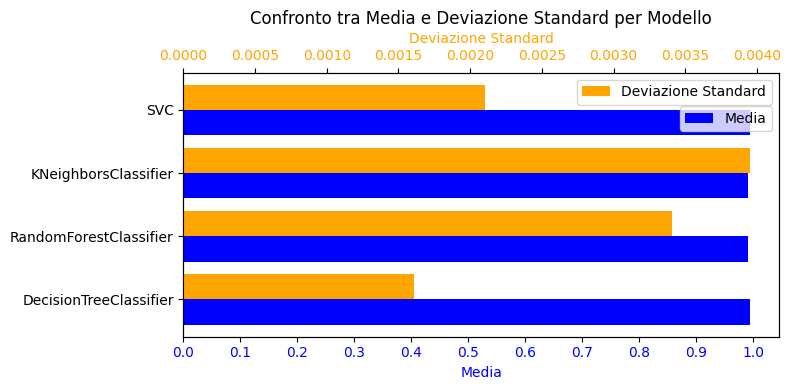

In [25]:
models_names = [f'{clf_dt.__class__.__name__}', f'{clf_rf.__class__.__name__}', f'{clf_knn.__class__.__name__}', f'{clf_svc.__class__.__name__}']
mean_values_undersampler_15m = [mean_accuracy_dt, mean_accuracy_rf, mean_accuracy_knn, mean_accuracy_svc] 
std_values_undersampler_15m = [std_accuracy_dt, std_accuracy_rf, std_accuracy_knn, std_accuracy_svc]

mean_graph_step = 0.1
std_graph_step = 0.0005

yindices = np.arange(len(models_names))

fig, ax1 = plt.subplots(figsize=(8, 4))

bars1 = ax1.barh(yindices - 0.2, mean_values_undersampler_15m, 0.4, label='Media', color='blue')
ax1.set_xlabel('Media', color='blue')
ax1.tick_params(axis='x', labelcolor='blue')

ax2 = ax1.twiny()
bars2 = ax2.barh(yindices + 0.2, std_values_undersampler_15m, 0.4, label='Deviazione Standard', color='orange')
ax2.set_xlabel('Deviazione Standard', color='orange')
ax2.tick_params(axis='x', labelcolor='orange')

ax1.set_title('Confronto tra Media e Deviazione Standard per Modello')
ax1.set_yticks(yindices)
ax1.set_yticklabels(models_names)

ax1.set_xticks(np.arange(0, max(mean_values_undersampler_15m)+mean_graph_step, mean_graph_step))
ax2.set_xticks(np.arange(0, max(std_values_undersampler_15m)+std_graph_step, std_graph_step))

ax1.legend(loc='upper right', bbox_to_anchor=(1, 0.9), fontsize='medium')
ax2.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize='medium')

plt.tight_layout()
plt.show()

##### Without Undersampler - Graph confusion matrix

In [26]:
accuracies_dt = []
accuracies_rf = []
accuracies_knn = []
accuracies_svc = []

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomstate_array[i])
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Decision Tree
    clf_dt = DecisionTreeClassifier(random_state=randomstate_array[i])
    clf_dt.fit(X_train_scaled, y_train)
    y_pred_dt = clf_dt.predict(X_test_scaled)
    accuracy_dt = accuracy_score(y_test, y_pred_dt)
    accuracies_dt.append(accuracy_dt)

    # Random Forest 
    clf_rf = RandomForestClassifier(random_state=randomstate_array[i])
    clf_rf.fit(X_train_scaled, y_train)
    y_pred_rf = clf_rf.predict(X_test_scaled)
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    accuracies_rf.append(accuracy_rf)

    # KNN
    clf_knn = KNeighborsClassifier()
    clf_knn.fit(X_train_scaled, y_train)
    y_pred_knn = clf_knn.predict(X_test_scaled)
    accuracy_knn = accuracy_score(y_test, y_pred_knn)
    accuracies_knn.append(accuracy_knn)

    # SVC
    clf_svc = SVC(random_state=randomstate_array[i])
    clf_svc.fit(X_train_scaled, y_train)
    y_pred_svc = clf_svc.predict(X_test_scaled)
    accuracy_svc = accuracy_score(y_test, y_pred_svc)
    accuracies_svc.append(accuracy_svc)


    iterations_name = {
            'Decision Tree': confusion_matrix(y_test, y_pred_dt),
            'Random Forest': confusion_matrix(y_test, y_pred_rf),
            'KNN': confusion_matrix(y_test, y_pred_knn),
            'SVC': confusion_matrix(y_test, y_pred_svc)
    }
	
    
    if os.path.exists(f"./results/result_notebook_timeaggr_{time_aggregation}s/test_15m_05h"):
        pass
    else:
        os.makedirs(f"./results/result_notebook_timeaggr_{time_aggregation}s/test_15m_05h")

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    for ax, (model_name, cm) in zip(axes.flatten(), iterations_name.items()):
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_title(f'Confusion Matrix: {model_name}')
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')
        plt.tight_layout()
        plt.savefig(f'./results/result_notebook_timeaggr_{time_aggregation}s/test_15m_05h/test_15m_iteration_{i}.png')
    plt.close()

mean_accuracy_dt = np.mean(accuracies_dt)
std_accuracy_dt = np.std(accuracies_dt)

mean_accuracy_rf = np.mean(accuracies_rf)
std_accuracy_rf = np.std(accuracies_rf)

mean_accuracy_knn = np.mean(accuracies_knn)
std_accuracy_knn = np.std(accuracies_knn)

mean_accuracy_svc = np.mean(accuracies_svc)
std_accuracy_svc = np.std(accuracies_svc)

print(f"Media delle accuratezze Decision Tree: {mean_accuracy_dt * 100:.2f}%, Deviazione standard: {std_accuracy_dt * 100:.2f}%")
print(f"Media delle accuratezze Random Forest: {mean_accuracy_rf * 100:.2f}%, Deviazione standard: {std_accuracy_rf * 100:.2f}%")
print(f"Media delle accuratezze KNN: {mean_accuracy_knn * 100:.2f}%, Deviazione standard: {std_accuracy_knn * 100:.2f}%")
print(f"Media delle accuratezze SVC: {mean_accuracy_svc * 100:.2f}%, Deviazione standard: {std_accuracy_svc * 100:.2f}%")

Media delle accuratezze Decision Tree: 99.47%, Deviazione standard: 0.21%
Media delle accuratezze Random Forest: 99.01%, Deviazione standard: 0.34%
Media delle accuratezze KNN: 99.03%, Deviazione standard: 0.40%
Media delle accuratezze SVC: 99.33%, Deviazione standard: 0.12%


###### Graph std-mean of ten accuracies

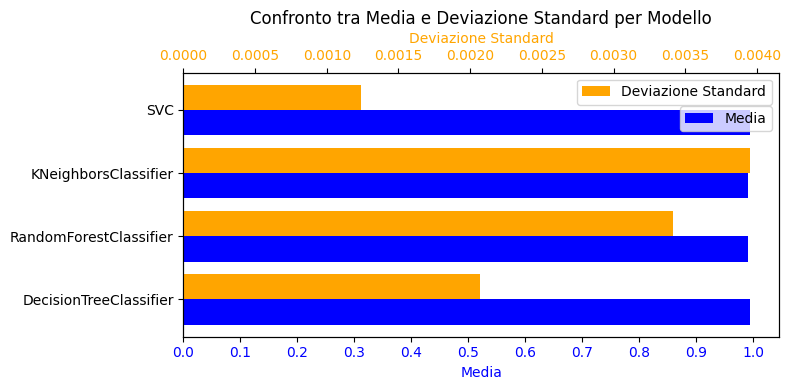

In [27]:
models_names = [f'{clf_dt.__class__.__name__}', f'{clf_rf.__class__.__name__}', f'{clf_knn.__class__.__name__}', f'{clf_svc.__class__.__name__}']
mean_values_15m = [mean_accuracy_dt, mean_accuracy_rf, mean_accuracy_knn, mean_accuracy_svc] 
std_values_15m = [std_accuracy_dt, std_accuracy_rf, std_accuracy_knn, std_accuracy_svc]

mean_graph_step = 0.1
std_graph_step = 0.0005

yindices = np.arange(len(models_names))

fig, ax1 = plt.subplots(figsize=(8, 4))

bars1 = ax1.barh(yindices - 0.2, mean_values_15m, 0.4, label='Media', color='blue')
ax1.set_xlabel('Media', color='blue')
ax1.tick_params(axis='x', labelcolor='blue')

ax2 = ax1.twiny()
bars2 = ax2.barh(yindices + 0.2, std_values_15m, 0.4, label='Deviazione Standard', color='orange')
ax2.set_xlabel('Deviazione Standard', color='orange')
ax2.tick_params(axis='x', labelcolor='orange')

ax1.set_title('Confronto tra Media e Deviazione Standard per Modello')
ax1.set_yticks(yindices)
ax1.set_yticklabels(models_names)

ax1.set_xticks(np.arange(0, max(mean_values_15m)+mean_graph_step, mean_graph_step))
ax2.set_xticks(np.arange(0, max(std_values_15m)+std_graph_step, std_graph_step))

ax1.legend(loc='upper right', bbox_to_anchor=(1, 0.9), fontsize='medium')
ax2.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize='medium')

plt.tight_layout()
plt.show()

# Ping Flooding - 5m attack - 30m capture

#### ETL and feature engineering

In [28]:
# ping flooding captures 1 min
pf_capture_1 = 'captures\\captures1_v2\\pingFloodDDoS\\eth2dump-pingFloodDDoS5m-0,5h_1.json'
pf_capture_2 = 'captures\\captures2\\pingFloodDDoS\\eth2dump-pingFloodDDoS5m-0,5h_1.json'
pf_capture_3='captures\\captures3\\pingFloodDDoS\\eth2dump-pingFloodDDoS5m-0,5h_1.json'

# nome dataframe su disco
dfclean_disk = "compressed_datasets\\captures1_v2\\clean\\df_clean.gzip"
dfpf1_disk_05_5 = "compressed_datasets\\captures1_v2\\pingFloodDDoS\\dfpf1_05_5.gzip"
dfpf2_disk_05_5= "compressed_datasets\\captures2\\pingFloodDDoS\\dfpf2_05_5.gzip"
dfpf3_disk_05_5 = "compressed_datasets\\captures3\\pingFloodDDoS\\dfpf3_05_5.gzip"

if not os.path.isfile(dfclean_disk):
	packets_cc = fn.load_packets_from_file(clean_capture)
	features_cc = fn.extract_features_from_packets(packets_cc, levels_of_interest)
	df_cc = pd.DataFrame(features_cc)
	features_cc.clear()
	df_cc.to_pickle(dfclean_disk, compression='gzip')
else:
	df_cc = pd.read_pickle(dfclean_disk, compression='gzip')

if not os.path.isfile(dfpf1_disk_05_5):
	pkt_pf_15m_05h = fn.load_packets_from_file(pf_capture_1)
	features_pf_15m_05h = fn.extract_features_from_packets(pkt_pf_15m_05h, levels_of_interest)
	df = pd.DataFrame(features_pf_15m_05h)
	features_pf_15m_05h.clear()
	df.to_pickle(dfpf1_disk_05_5, compression='gzip')
else:
	df = pd.read_pickle(dfpf1_disk_05_5, compression='gzip')

if not os.path.isfile(dfpf2_disk_05_5):
	pkt_pf_15m_05h_2 = fn.load_packets_from_file(pf_capture_2)
	features_pf_15m_05h_2 = fn.extract_features_from_packets(pkt_pf_15m_05h_2, levels_of_interest)
	df1 = pd.DataFrame(features_pf_15m_05h_2)
	features_pf_15m_05h_2.clear()
	df1.to_pickle(dfpf2_disk_05_5, compression='gzip')
else:
	df1 = pd.read_pickle(dfpf2_disk_05_5, compression='gzip')

if not os.path.isfile(dfpf3_disk_05_5):
	pkt_pf_15m_05h_3 = fn.load_packets_from_file(pf_capture_3)
	features_pf_15m_05h_3 = fn.extract_features_from_packets(pkt_pf_15m_05h_3, levels_of_interest)
	df2 = pd.DataFrame(features_pf_15m_05h_3)
	features_pf_15m_05h_3.clear()
	df2.to_pickle(dfpf3_disk_05_5, compression='gzip')
else:
	df2 = pd.read_pickle(dfpf3_disk_05_5, compression='gzip')

In [29]:
fn.calcolo_features_binarie(df_cc)
fn.calcolo_features_binarie(df)
fn.calcolo_features_binarie(df1)
fn.calcolo_features_binarie(df2)

In [30]:
df_cc['frame.frame.time_utc'] = pd.to_datetime(df_cc['frame.frame.time_utc'])
df['frame.frame.time_utc'] = pd.to_datetime(df['frame.frame.time_utc'])
df1['frame.frame.time_utc'] = pd.to_datetime(df1['frame.frame.time_utc'])
df2['frame.frame.time_utc'] = pd.to_datetime(df2['frame.frame.time_utc'])

In [31]:
df_cc.sort_values(by='frame.frame.time_utc')
df.sort_values(by='frame.frame.time_utc')
df1.sort_values(by='frame.frame.time_utc')
df2.sort_values(by='frame.frame.time_utc')

,frame.frame.encap_type,frame.frame.time,frame.frame.time_utc,frame.frame.time_epoch,frame.frame.offset_shift,frame.frame.time_delta,frame.frame.time_delta_displayed,frame.frame.time_relative,frame.frame.number,frame.frame.len,...,browser,smb,llc,mbtcp,dhcp,arp,llmnr,ipv6,nbdgm,stp
0,1,"Aug 8, 2018 19:06:45.892610000 ora legale Eur...",2018-08-08 17:06:45.892610+00:00,1533748005.892610000,0.000000000,0.000000000,0.000000000,0.000000000,1,66,...,0,0,0,1,0,0,0,0,0,0
1,1,"Aug 8, 2018 19:06:45.896992000 ora legale Eur...",2018-08-08 17:06:45.896992+00:00,1533748005.896992000,0.000000000,0.004382000,0.004382000,0.004382000,2,85,...,0,0,0,1,0,0,0,0,0,0
2,1,"Aug 8, 2018 19:06:45.954339000 ora legale Eur...",2018-08-08 17:06:45.954339+00:00,1533748005.954339000,0.000000000,0.057347000,0.057347000,0.061729000,3,64,...,0,0,1,0,0,0,0,0,0,1
3,1,"Aug 8, 2018 19:06:46.110235000 ora legale Eur...",2018-08-08 17:06:46.110235+00:00,1533748006.110235000,0.000000000,0.155896000,0.155896000,0.217625000,4,60,...,0,0,0,0,0,0,0,0,0,0
4,1,"Aug 8, 2018 19:06:46.204464000 ora legale Eur...",2018-08-08 17:06:46.204464+00:00,1533748006.204464000,0.000000000,0.094229000,0.094229000,0.311854000,5,66,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94295,1,"Aug 8, 2018 19:36:44.662447000 ora legale Eur...",2018-08-08 17:36:44.662447+00:00,1533749804.662447000,0.000000000,0.010439000,0.010439000,1798.769837000,94296,85,...,0,0,0,1,0,0,0,0,0,0
94296,1,"Aug 8, 2018 19:36:44.869635000 ora legale Eur...",2018-08-08 17:36:44.869635+00:00,1533749804.869635000,0.000000000,0.207188000,0.207188000,1798.977025000,94297,60,...,0,0,0,0,0,0,0,0,0,0
94297,1,"Aug 8, 2018 19:36:44.963849000 ora legale Eur...",2018-08-08 17:36:44.963849+00:00,1533749804.963849000,0.000000000,0.094214000,0.094214000,1799.071239000,94298,66,...,0,0,0,1,0,0,0,0,0,0
94298,1,"Aug 8, 2018 19:36:44.971791000 ora legale Eur...",2018-08-08 17:36:44.971791+00:00,1533749804.971791000,0.000000000,0.007942000,0.007942000,1799.079181000,94299,85,...,0,0,0,1,0,0,0,0,0,0


In [32]:
start_time = df['frame.frame.time_utc'].iloc[0]
end_time=start_time+timedelta(seconds=303)
end_time2 = end_time + timedelta(seconds=300)

In [33]:
start_time_2 = df1['frame.frame.time_utc'].iloc[0]
end_time_2=start_time_2+timedelta(seconds=299)
end_time2_2 = end_time_2 + timedelta(seconds=300)

In [34]:
start_time_3 = df2['frame.frame.time_utc'].iloc[0]
end_time_3=start_time_3+timedelta(seconds=299)
end_time2_3 = end_time_3 + timedelta(seconds=310)

In [35]:
df_cc1 = df[(df['frame.frame.time_utc'] >= start_time) & (df['frame.frame.time_utc'] < end_time)].copy()
df_attack = df[(df['frame.frame.time_utc'] >= end_time) & (df['frame.frame.time_utc'] <= end_time2)].copy()
df_cc2 = df[(df['frame.frame.time_utc'] > end_time2)].copy()

In [36]:
df1_cc1_2 = df1[(df1['frame.frame.time_utc'] >= start_time_2) & (df1['frame.frame.time_utc'] < end_time_2)].copy()
df1_attack_2 = df1[(df1['frame.frame.time_utc'] >= end_time_2) & (df1['frame.frame.time_utc'] <= end_time2_2)].copy()
df1_cc2_2 = df1[(df1['frame.frame.time_utc'] > end_time2_2)].copy()

In [37]:
df2_cc1_3 = df2[(df2['frame.frame.time_utc'] >= start_time_3) & (df2['frame.frame.time_utc'] < end_time_3)].copy()
df2_attack_3 = df2[(df2['frame.frame.time_utc'] >= end_time_3) & (df2['frame.frame.time_utc'] <= end_time2_3)].copy()
df2_cc2_3 = df2[(df2['frame.frame.time_utc'] > end_time2_3)].copy()

In [38]:
df_cc_aggregation = fn.calcola_features(df_cc, time_aggregation)
df_cc1_aggregation = fn.calcola_features(df_cc1, time_aggregation)
df_cc2_aggregation = fn.calcola_features(df_cc2, time_aggregation)
df_att_aggregation = fn.calcola_features(df_attack, time_aggregation)

In [39]:
df1_cc1_aggregation = fn.calcola_features(df1_cc1_2, time_aggregation)
df1_att_aggregation = fn.calcola_features(df1_attack_2, time_aggregation)
df1_cc2_aggregation = fn.calcola_features(df1_cc2_2, time_aggregation)

In [40]:
df2_cc1_aggregation = fn.calcola_features(df2_cc1_3, time_aggregation)
df2_att_aggregation = fn.calcola_features(df2_attack_3, time_aggregation)
df2_cc2_aggregation = fn.calcola_features(df2_cc2_3, time_aggregation)

In [41]:
df_cc_aggregation['label']=0
df_cc1_aggregation['label']=0
df_cc2_aggregation ['label']=0
df_att_aggregation ['label']=1

df1_cc1_aggregation['label']=0
df1_att_aggregation['label']=1
df1_cc2_aggregation['label']=0

df2_cc1_aggregation['label']=0
df2_att_aggregation['label']=1
df2_cc2_aggregation['label']=0

In [42]:
df_tot = pd.concat([df_cc_aggregation,df_cc1_aggregation,df_cc2_aggregation,df_att_aggregation,df1_cc1_aggregation,df1_att_aggregation,df1_cc2_aggregation,df2_cc1_aggregation, df2_att_aggregation,df2_cc2_aggregation], axis=0)

In [43]:
df_tot['ipat_std'] = df_tot['ipat_std'].dt.total_seconds()
df_tot['ipat_max'] = df_tot['ipat_max'].dt.total_seconds()
df_tot['ipat_min'] = df_tot['ipat_min'].dt.total_seconds()
df_tot['ipat_mode'] = df_tot['ipat_mode'].dt.total_seconds()

In [44]:
df_tot = df_tot.fillna(0)

In [45]:
X = df_tot.drop(columns='label')  
y = df_tot['label'] 

#### Test ANOVA

In [46]:
f_values, p_values = f_classif(X, y)
anova_results = pd.DataFrame({
    'Feature': X.columns,
    'F-value': f_values,
    'P-value': p_values
})
anova_results_sorted = anova_results.sort_values(by='P-value')
# Creazione colonna per segnalare se la feature può essere scartata (P-value > 0.05)
anova_results_sorted['Discard'] = anova_results_sorted['P-value'] > 0.05
# Mostrare le colonne che possono essere scartate
features_to_discard = anova_results_sorted[anova_results_sorted['Discard']]['Feature'].tolist()
print("\nColonne che possono essere scartate:", features_to_discard)


Colonne che possono essere scartate: ['ipat_mode', 'tcp_syn_count', 'ipat_min', 'udp_count', 'ip_dst_mode']


In [47]:
X.drop(inplace=True, columns=features_to_discard)

#### Models training-testing

##### With Undersampler - Graph confusion matrix

In [48]:
accuracies_dt = []
accuracies_rf = []
accuracies_knn = []
accuracies_svc = []

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomstate_array[i])
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    undersampler = RandomUnderSampler(random_state=randomstate_array[i])
    X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train_scaled, y_train)


	#Decision Tree
    clf_dt = DecisionTreeClassifier(random_state=randomstate_array[i])
    clf_dt.fit(X_train_balanced, y_train_balanced)
    y_pred_dt = clf_dt.predict(X_test_scaled)
    accuracy_dt = accuracy_score(y_test, y_pred_dt)
    accuracies_dt.append(accuracy_dt)

    #Random Forest 
    clf_rf = RandomForestClassifier(random_state=randomstate_array[i])
    clf_rf.fit(X_train_balanced, y_train_balanced)
    y_pred_rf = clf_rf.predict(X_test_scaled)
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    accuracies_rf.append(accuracy_rf)

    #  (KNN)
    clf_knn = KNeighborsClassifier()
    clf_knn.fit(X_train_balanced, y_train_balanced)
    y_pred_knn = clf_knn.predict(X_test_scaled)
    accuracy_knn = accuracy_score(y_test, y_pred_knn)
    accuracies_knn.append(accuracy_knn)

    # (SVC)
    clf_svc = SVC(random_state=randomstate_array[i])
    clf_svc.fit(X_train_balanced, y_train_balanced)
    y_pred_svc = clf_svc.predict(X_test_scaled)
    accuracy_svc = accuracy_score(y_test, y_pred_svc)
    accuracies_svc.append(accuracy_svc)

    iterations_name = {
            'Decision Tree': confusion_matrix(y_test, y_pred_dt),
            'Random Forest': confusion_matrix(y_test, y_pred_rf),
            'KNN': confusion_matrix(y_test, y_pred_knn),
            'SVC': confusion_matrix(y_test, y_pred_svc)
    }
	
    
    if os.path.exists(f"./results/result_notebook_timeaggr_{time_aggregation}s/test_5m_05h_un"):
        pass
    else:
        os.makedirs(f"./results/result_notebook_timeaggr_{time_aggregation}s/test_5m_05h_un")

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    for ax, (model_name, cm) in zip(axes.flatten(), iterations_name.items()):
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_title(f'Confusion Matrix: {model_name}')
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')
        plt.tight_layout()
        plt.savefig(f'./results/result_notebook_timeaggr_{time_aggregation}s/test_5m_05h_un/test_5m_iteration_{i}_un.png')
    plt.close()



mean_accuracy_dt = np.mean(accuracies_dt)
std_accuracy_dt = np.std(accuracies_dt)

mean_accuracy_rf = np.mean(accuracies_rf)
std_accuracy_rf = np.std(accuracies_rf)

mean_accuracy_knn = np.mean(accuracies_knn)
std_accuracy_knn = np.std(accuracies_knn)

mean_accuracy_svc = np.mean(accuracies_svc)
std_accuracy_svc = np.std(accuracies_svc)

print(f"Media delle accuratezze Decision Tree: {mean_accuracy_dt * 100:.2f}%, Deviazione standard: {std_accuracy_dt * 100:.2f}%")
print(f"Media delle accuratezze Random Forest: {mean_accuracy_rf * 100:.2f}%, Deviazione standard: {std_accuracy_rf * 100:.2f}%")
print(f"Media delle accuratezze KNN: {mean_accuracy_knn * 100:.2f}%, Deviazione standard: {std_accuracy_knn * 100:.2f}%")
print(f"Media delle accuratezze SVC: {mean_accuracy_svc * 100:.2f}%, Deviazione standard: {std_accuracy_svc * 100:.2f}%")



Media delle accuratezze Decision Tree: 99.03%, Deviazione standard: 0.35%
Media delle accuratezze Random Forest: 99.52%, Deviazione standard: 0.32%
Media delle accuratezze KNN: 99.49%, Deviazione standard: 0.41%
Media delle accuratezze SVC: 99.08%, Deviazione standard: 0.37%


###### Graph std-mean of ten accuracies

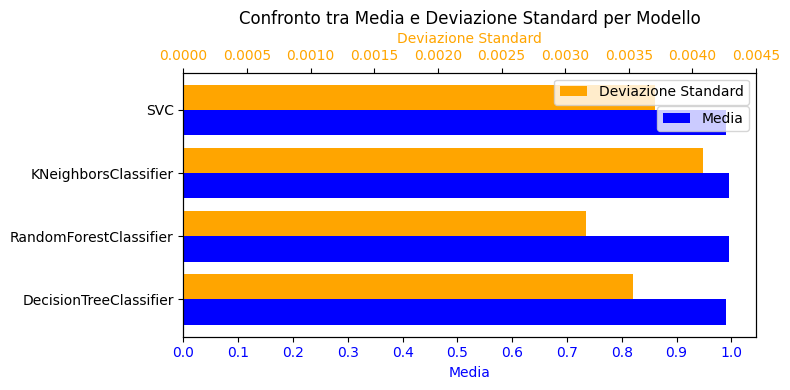

In [49]:
models_names = [f'{clf_dt.__class__.__name__}', f'{clf_rf.__class__.__name__}', f'{clf_knn.__class__.__name__}', f'{clf_svc.__class__.__name__}']
mean_values_undersampler_5m = [mean_accuracy_dt, mean_accuracy_rf, mean_accuracy_knn, mean_accuracy_svc] 
std_values_undersampler_5m = [std_accuracy_dt, std_accuracy_rf, std_accuracy_knn, std_accuracy_svc]

mean_graph_step = 0.1
std_graph_step = 0.0005

yindices = np.arange(len(models_names))

fig, ax1 = plt.subplots(figsize=(8, 4))

bars1 = ax1.barh(yindices - 0.2, mean_values_undersampler_5m, 0.4, label='Media', color='blue')
ax1.set_xlabel('Media', color='blue')
ax1.tick_params(axis='x', labelcolor='blue')

ax2 = ax1.twiny()
bars2 = ax2.barh(yindices + 0.2, std_values_undersampler_5m, 0.4, label='Deviazione Standard', color='orange')
ax2.set_xlabel('Deviazione Standard', color='orange')
ax2.tick_params(axis='x', labelcolor='orange')

ax1.set_title('Confronto tra Media e Deviazione Standard per Modello')
ax1.set_yticks(yindices)
ax1.set_yticklabels(models_names)

ax1.set_xticks(np.arange(0, max(mean_values_undersampler_5m)+mean_graph_step, mean_graph_step))
ax2.set_xticks(np.arange(0, max(std_values_undersampler_5m)+std_graph_step, std_graph_step))

ax1.legend(loc='upper right', bbox_to_anchor=(1, 0.9), fontsize='medium')
ax2.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize='medium')

plt.tight_layout()
plt.show()

##### Without Undersampler - Graph confusion matrix

In [50]:
accuracies_dt = []
accuracies_rf = []
accuracies_knn = []
accuracies_svc = []

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomstate_array[i])
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Decision Tree
    clf_dt = DecisionTreeClassifier(random_state=randomstate_array[i])
    clf_dt.fit(X_train_scaled, y_train)
    y_pred_dt = clf_dt.predict(X_test_scaled)
    accuracy_dt = accuracy_score(y_test, y_pred_dt)
    accuracies_dt.append(accuracy_dt)

    # Random Forest 
    clf_rf = RandomForestClassifier(random_state=randomstate_array[i])
    clf_rf.fit(X_train_scaled, y_train)
    y_pred_rf = clf_rf.predict(X_test_scaled)
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    accuracies_rf.append(accuracy_rf)

    # KNN
    clf_knn = KNeighborsClassifier()
    clf_knn.fit(X_train_scaled, y_train)
    y_pred_knn = clf_knn.predict(X_test_scaled)
    accuracy_knn = accuracy_score(y_test, y_pred_knn)
    accuracies_knn.append(accuracy_knn)

    # SVC
    clf_svc = SVC(random_state=randomstate_array[i])
    clf_svc.fit(X_train_scaled, y_train)
    y_pred_svc = clf_svc.predict(X_test_scaled)
    accuracy_svc = accuracy_score(y_test, y_pred_svc)
    accuracies_svc.append(accuracy_svc)


    if os.path.exists(f"./results/result_notebook_timeaggr_{time_aggregation}s/test_5m_05h"):
        pass
    else:
        os.makedirs(f"./results/result_notebook_timeaggr_{time_aggregation}s/test_5m_05h")

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    for ax, (model_name, cm) in zip(axes.flatten(), iterations_name.items()):
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_title(f'Confusion Matrix: {model_name}')
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')
        plt.tight_layout()
        plt.savefig(f'./results/result_notebook_timeaggr_{time_aggregation}s/test_5m_05h/test_5m_iteration_{i}.png')
    plt.close()

mean_accuracy_dt = np.mean(accuracies_dt)
std_accuracy_dt = np.std(accuracies_dt)

mean_accuracy_rf = np.mean(accuracies_rf)
std_accuracy_rf = np.std(accuracies_rf)

mean_accuracy_knn = np.mean(accuracies_knn)
std_accuracy_knn = np.std(accuracies_knn)

mean_accuracy_svc = np.mean(accuracies_svc)
std_accuracy_svc = np.std(accuracies_svc)

print(f"Media delle accuratezze Decision Tree: {mean_accuracy_dt * 100:.2f}%, Deviazione standard: {std_accuracy_dt * 100:.2f}%")
print(f"Media delle accuratezze Random Forest: {mean_accuracy_rf * 100:.2f}%, Deviazione standard: {std_accuracy_rf * 100:.2f}%")
print(f"Media delle accuratezze KNN: {mean_accuracy_knn * 100:.2f}%, Deviazione standard: {std_accuracy_knn * 100:.2f}%")
print(f"Media delle accuratezze SVC: {mean_accuracy_svc * 100:.2f}%, Deviazione standard: {std_accuracy_svc * 100:.2f}%")

Media delle accuratezze Decision Tree: 99.40%, Deviazione standard: 0.33%
Media delle accuratezze Random Forest: 99.56%, Deviazione standard: 0.32%
Media delle accuratezze KNN: 99.54%, Deviazione standard: 0.36%
Media delle accuratezze SVC: 99.47%, Deviazione standard: 0.41%


###### Graph std-mean of ten accuracies

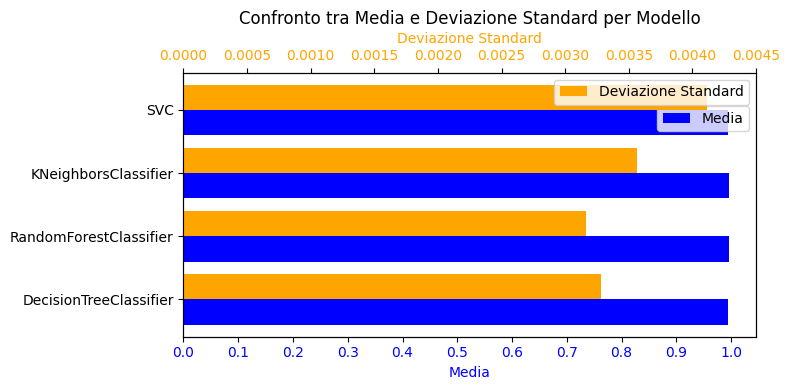

In [51]:
models_names = [f'{clf_dt.__class__.__name__}', f'{clf_rf.__class__.__name__}', f'{clf_knn.__class__.__name__}', f'{clf_svc.__class__.__name__}']
mean_values_5m = [mean_accuracy_dt, mean_accuracy_rf, mean_accuracy_knn, mean_accuracy_svc] 
std_values_5m = [std_accuracy_dt, std_accuracy_rf, std_accuracy_knn, std_accuracy_svc]

mean_graph_step = 0.1
std_graph_step = 0.0005

yindices = np.arange(len(models_names))

fig, ax1 = plt.subplots(figsize=(8, 4))

bars1 = ax1.barh(yindices - 0.2, mean_values_5m, 0.4, label='Media', color='blue')
ax1.set_xlabel('Media', color='blue')
ax1.tick_params(axis='x', labelcolor='blue')

ax2 = ax1.twiny()
bars2 = ax2.barh(yindices + 0.2, std_values_5m, 0.4, label='Deviazione Standard', color='orange')
ax2.set_xlabel('Deviazione Standard', color='orange')
ax2.tick_params(axis='x', labelcolor='orange')

ax1.set_title('Confronto tra Media e Deviazione Standard per Modello')
ax1.set_yticks(yindices)
ax1.set_yticklabels(models_names)

ax1.set_xticks(np.arange(0, max(mean_values_5m)+mean_graph_step, mean_graph_step))
ax2.set_xticks(np.arange(0, max(std_values_5m)+std_graph_step, std_graph_step))

ax1.legend(loc='upper right', bbox_to_anchor=(1, 0.9), fontsize='medium')
ax2.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize='medium')

plt.tight_layout()
plt.show()

# Ping Flooding - 1m attack - 30m capture

#### ETL and feature engineering

In [52]:
pf_capture_1 = 'captures\\captures1_v2\\pingFloodDDoS\\eth2dump-pingFloodDDoS1m-0,5h_1.json'
pf_capture_2 = 'captures\\captures2\\pingFloodDDoS\\eth2dump-pingFloodDDoS1m-0,5h_1.json'
pf_capture_3='captures\\captures3\\pingFloodDDoS\\eth2dump-pingFloodDDoS1m-0,5h_1.json'

dfpf1_disk_05_1 = "compressed_datasets\\captures1_v2\\pingFloodDDoS\\dfpf1_05_1.gzip"
dfpf2_disk_05_1= "compressed_datasets\\captures2\\pingFloodDDoS\\dfpf2_05_1.gzip"
dfpf3_disk_05_1= "compressed_datasets\\captures3\\pingFloodDDoS\\dfpf3_05_1.gzip"

if not os.path.isfile(dfclean_disk):
	packets_cc = fn.load_packets_from_file(clean_capture)
	features_cc = fn.extract_features_from_packets(packets_cc, levels_of_interest)
	df_cc = pd.DataFrame(features_cc)
	features_cc.clear()
	df_cc.to_pickle(dfclean_disk, compression='gzip')
else:
	df_cc = pd.read_pickle(dfclean_disk, compression='gzip')

if not os.path.isfile(dfpf1_disk_05_1):
	pkt_pf_15m_05h = fn.load_packets_from_file(pf_capture_1)
	features_pf_15m_05h = fn.extract_features_from_packets(pkt_pf_15m_05h, levels_of_interest)
	df = pd.DataFrame(features_pf_15m_05h)
	features_pf_15m_05h.clear()
	df.to_pickle(dfpf1_disk_05_1, compression='gzip')
else:
	df = pd.read_pickle(dfpf1_disk_05_1, compression='gzip')

if not os.path.isfile(dfpf2_disk_05_1):
	pkt_pf_15m_05h_2 = fn.load_packets_from_file(pf_capture_2)
	features_pf_15m_05h_2 = fn.extract_features_from_packets(pkt_pf_15m_05h_2, levels_of_interest)
	df1 = pd.DataFrame(features_pf_15m_05h_2)
	features_pf_15m_05h_2.clear()
	df1.to_pickle(dfpf2_disk_05_1, compression='gzip')
else:
	df1 = pd.read_pickle(dfpf2_disk_05_1, compression='gzip')

if not os.path.isfile(dfpf3_disk_05_1):
	pkt_pf_15m_05h_3 = fn.load_packets_from_file(pf_capture_3)
	features_pf_15m_05h_3 = fn.extract_features_from_packets(pkt_pf_15m_05h_3, levels_of_interest)
	df2 = pd.DataFrame(features_pf_15m_05h_3)
	features_pf_15m_05h_3.clear()
	df2.to_pickle(dfpf3_disk_05_1, compression='gzip')
else:
	df2 = pd.read_pickle(dfpf3_disk_05_1, compression='gzip')

In [53]:
fn.calcolo_features_binarie(df_cc)
fn.calcolo_features_binarie(df)
fn.calcolo_features_binarie(df1)
fn.calcolo_features_binarie(df2)

In [54]:
df_cc['frame.frame.time_utc'] = pd.to_datetime(df_cc['frame.frame.time_utc'])
df['frame.frame.time_utc'] = pd.to_datetime(df['frame.frame.time_utc'])
df1['frame.frame.time_utc'] = pd.to_datetime(df1['frame.frame.time_utc'])
df2['frame.frame.time_utc'] = pd.to_datetime(df2['frame.frame.time_utc'])

In [55]:
df_cc.sort_values(by='frame.frame.time_utc')
df.sort_values(by='frame.frame.time_utc')
df1.sort_values(by='frame.frame.time_utc')
df2.sort_values(by='frame.frame.time_utc')
df1

,frame.frame.encap_type,frame.frame.time,frame.frame.time_utc,frame.frame.time_epoch,frame.frame.offset_shift,frame.frame.time_delta,frame.frame.time_delta_displayed,frame.frame.time_relative,frame.frame.number,frame.frame.len,...,browser,smb,llc,mbtcp,dhcp,arp,llmnr,ipv6,nbdgm,stp
0,1,"Aug 9, 2018 01:26:58.620063000 ora legale Eur...",2018-08-08 23:26:58.620063+00:00,1533770818.620063000,0.000000000,0.000000000,0.000000000,0.000000000,1,60,...,0,0,0,0,0,0,0,0,0,0
1,1,"Aug 9, 2018 01:26:58.684916000 ora legale Eur...",2018-08-08 23:26:58.684916+00:00,1533770818.684916000,0.000000000,0.064853000,0.064853000,0.064853000,2,60,...,0,0,0,0,0,0,0,0,0,0
2,1,"Aug 9, 2018 01:26:58.714934000 ora legale Eur...",2018-08-08 23:26:58.714934+00:00,1533770818.714934000,0.000000000,0.030018000,0.030018000,0.094871000,3,66,...,0,0,0,1,0,0,0,0,0,0
3,1,"Aug 9, 2018 01:26:58.721864000 ora legale Eur...",2018-08-08 23:26:58.721864+00:00,1533770818.721864000,0.000000000,0.006930000,0.006930000,0.101801000,4,85,...,0,0,0,1,0,0,0,0,0,0
4,1,"Aug 9, 2018 01:26:58.932079000 ora legale Eur...",2018-08-08 23:26:58.932079+00:00,1533770818.932079000,0.000000000,0.210215000,0.210215000,0.312016000,5,60,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47167,1,"Aug 9, 2018 01:56:58.038543000 ora legale Eur...",2018-08-08 23:56:58.038543+00:00,1533772618.038543000,0.000000000,0.000853000,0.000853000,1799.418480000,47168,66,...,0,0,0,1,0,0,0,0,0,0
47168,1,"Aug 9, 2018 01:56:58.117276000 ora legale Eur...",2018-08-08 23:56:58.117276+00:00,1533772618.117276000,0.000000000,0.078733000,0.078733000,1799.497213000,47169,60,...,0,0,0,0,0,0,0,0,0,0
47169,1,"Aug 9, 2018 01:56:58.227295000 ora legale Eur...",2018-08-08 23:56:58.227295+00:00,1533772618.227295000,0.000000000,0.110019000,0.110019000,1799.607232000,47170,66,...,0,0,0,1,0,0,0,0,0,0
47170,1,"Aug 9, 2018 01:56:58.237737000 ora legale Eur...",2018-08-08 23:56:58.237737+00:00,1533772618.237737000,0.000000000,0.010442000,0.010442000,1799.617674000,47171,85,...,0,0,0,1,0,0,0,0,0,0


In [56]:
start_time = df['frame.frame.time_utc'].iloc[0]
end_time=start_time+timedelta(seconds=298)
end_time2 = end_time + timedelta(seconds=60)

In [57]:
start_time_2 = df1['frame.frame.time_utc'].iloc[0]
end_time_2=start_time_2+timedelta(seconds=299)
end_time2_2 = end_time_2 + timedelta(seconds=60)

In [58]:
start_time_3 = df2['frame.frame.time_utc'].iloc[0]
end_time_3=start_time_3+timedelta(seconds=299)
end_time2_3 = end_time_3 + timedelta(seconds=60)

In [59]:
df_cc1 = df[(df['frame.frame.time_utc'] >= start_time) & (df['frame.frame.time_utc'] < end_time)].copy()
df_attack = df[(df['frame.frame.time_utc'] >= end_time) & (df['frame.frame.time_utc'] <= end_time2)].copy()
df_cc2 = df[(df['frame.frame.time_utc'] > end_time2)].copy()

In [60]:
df1_cc1_2 = df1[(df1['frame.frame.time_utc'] >= start_time_2) & (df1['frame.frame.time_utc'] < end_time_2)].copy()
df1_attack_2 = df1[(df1['frame.frame.time_utc'] >= end_time_2) & (df1['frame.frame.time_utc'] <= end_time2_2)].copy()
df1_cc2_2 = df1[(df1['frame.frame.time_utc'] > end_time2_2)].copy()

In [61]:
df2_cc1_3 = df2[(df2['frame.frame.time_utc'] >= start_time_3) & (df2['frame.frame.time_utc'] < end_time_3)].copy()
df2_attack_3 = df2[(df2['frame.frame.time_utc'] >= end_time_3) & (df2['frame.frame.time_utc'] <= end_time2_3)].copy()
df2_cc2_3 = df2[(df2['frame.frame.time_utc'] > end_time2_3)].copy()

In [62]:
df_cc_aggregation = fn.calcola_features(df_cc, time_aggregation)
df_cc1_aggregation = fn.calcola_features(df_cc1, time_aggregation)
df_cc2_aggregation = fn.calcola_features(df_cc2, time_aggregation)
df_att_aggregation = fn.calcola_features(df_attack, time_aggregation)

In [63]:
df1_cc1_aggregation = fn.calcola_features(df1_cc1_2, time_aggregation)
df1_att_aggregation = fn.calcola_features(df1_attack_2, time_aggregation)
df1_cc2_aggregation = fn.calcola_features(df1_cc2_2, time_aggregation)

In [64]:
df2_cc1_aggregation = fn.calcola_features(df2_cc1_3, time_aggregation)
df2_att_aggregation = fn.calcola_features(df2_attack_3, time_aggregation)
df2_cc2_aggregation = fn.calcola_features(df2_cc2_3, time_aggregation)

In [65]:
df_cc_aggregation['label']=0
df_cc1_aggregation['label']=0
df_cc2_aggregation ['label']=0
df_att_aggregation ['label']=1

df1_cc1_aggregation['label']=0
df1_att_aggregation['label']=1
df1_cc2_aggregation['label']=0

df2_cc1_aggregation['label']=0
df2_att_aggregation['label']=1
df2_cc2_aggregation['label']=0

In [66]:
df_tot = pd.concat([df_cc_aggregation,df_cc1_aggregation,df_cc2_aggregation,df_att_aggregation,df1_cc1_aggregation,df1_att_aggregation,df1_cc2_aggregation,df2_cc1_aggregation, df2_att_aggregation,df2_cc2_aggregation], axis=0)

In [67]:
df_tot['ipat_std'] = df_tot['ipat_std'].dt.total_seconds()
df_tot['ipat_max'] = df_tot['ipat_max'].dt.total_seconds()
df_tot['ipat_min'] = df_tot['ipat_min'].dt.total_seconds()
df_tot['ipat_mode'] = df_tot['ipat_mode'].dt.total_seconds()

In [68]:
df_tot = df_tot.fillna(0)

In [69]:
X = df_tot.drop(columns='label')  
y = df_tot['label'] 

#### Test ANOVA

In [70]:
f_values, p_values = f_classif(X, y)
anova_results = pd.DataFrame({
    'Feature': X.columns,
    'F-value': f_values,
    'P-value': p_values
})
anova_results_sorted = anova_results.sort_values(by='P-value')
# Creazione colonna per segnalare se la feature può essere scartata (P-value > 0.05)
anova_results_sorted['Discard'] = anova_results_sorted['P-value'] > 0.05
# Mostrare le colonne che possono essere scartate
features_to_discard = anova_results_sorted[anova_results_sorted['Discard']]['Feature'].tolist()
print("\nColonne che possono essere scartate:", features_to_discard)


Colonne che possono essere scartate: ['mbtcp_count', 'modbus_response_count', 'modbus_request_count', 'tcp_syn_count', 'modb_req_resp_fraction', 'udp_count', 'tcp_synack_fraction', 'ipat_min', 'ip_src_mode', 'ip_dst_mode', 'ipat_mode']


In [71]:
X.drop(inplace=True, columns=features_to_discard)

#### Models training-testing

##### With Undersampler - Graph confusion matrix

In [72]:
accuracies_dt = []
accuracies_rf = []
accuracies_knn = []
accuracies_svc = []

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomstate_array[i])
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    undersampler = RandomUnderSampler(random_state=randomstate_array[i])
    X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train_scaled, y_train)


	# Decision Tree
    clf_dt = DecisionTreeClassifier(random_state=randomstate_array[i])
    clf_dt.fit(X_train_balanced, y_train_balanced)
    y_pred_dt = clf_dt.predict(X_test_scaled)
    accuracy_dt = accuracy_score(y_test, y_pred_dt)
    accuracies_dt.append(accuracy_dt)

    # Random Forest 
    clf_rf = RandomForestClassifier(random_state=randomstate_array[i])
    clf_rf.fit(X_train_balanced, y_train_balanced)
    y_pred_rf = clf_rf.predict(X_test_scaled)
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    accuracies_rf.append(accuracy_rf)

    # KNN
    clf_knn = KNeighborsClassifier()
    clf_knn.fit(X_train_balanced, y_train_balanced)
    y_pred_knn = clf_knn.predict(X_test_scaled)
    accuracy_knn = accuracy_score(y_test, y_pred_knn)
    accuracies_knn.append(accuracy_knn)

    # SVC
    clf_svc = SVC(random_state=randomstate_array[i])
    clf_svc.fit(X_train_balanced, y_train_balanced)
    y_pred_svc = clf_svc.predict(X_test_scaled)
    accuracy_svc = accuracy_score(y_test, y_pred_svc)
    accuracies_svc.append(accuracy_svc)
    
    if os.path.exists(f"./results/result_notebook_timeaggr_{time_aggregation}s/test_1m_05h_un"):
        pass
    else:
        os.makedirs(f"./results/result_notebook_timeaggr_{time_aggregation}s/test_1m_05h_un")

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    for ax, (model_name, cm) in zip(axes.flatten(), iterations_name.items()):
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_title(f'Confusion Matrix: {model_name}')
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')
        plt.tight_layout()
        plt.savefig(f'./results/result_notebook_timeaggr_{time_aggregation}s/test_1m_05h_un/test_1m_iteration_{i}_un.png')
    plt.close()

mean_accuracy_dt = np.mean(accuracies_dt)
std_accuracy_dt = np.std(accuracies_dt)

mean_accuracy_rf = np.mean(accuracies_rf)
std_accuracy_rf = np.std(accuracies_rf)

mean_accuracy_knn = np.mean(accuracies_knn)
std_accuracy_knn = np.std(accuracies_knn)

mean_accuracy_svc = np.mean(accuracies_svc)
std_accuracy_svc = np.std(accuracies_svc)

print(f"Media delle accuratezze Decision Tree: {mean_accuracy_dt * 100:.2f}%, Deviazione standard: {std_accuracy_dt * 100:.2f}%")
print(f"Media delle accuratezze Random Forest: {mean_accuracy_rf * 100:.2f}%, Deviazione standard: {std_accuracy_rf * 100:.2f}%")
print(f"Media delle accuratezze KNN: {mean_accuracy_knn * 100:.2f}%, Deviazione standard: {std_accuracy_knn * 100:.2f}%")
print(f"Media delle accuratezze SVC: {mean_accuracy_svc * 100:.2f}%, Deviazione standard: {std_accuracy_svc * 100:.2f}%")



Media delle accuratezze Decision Tree: 99.72%, Deviazione standard: 0.34%
Media delle accuratezze Random Forest: 99.84%, Deviazione standard: 0.15%
Media delle accuratezze KNN: 99.77%, Deviazione standard: 0.25%
Media delle accuratezze SVC: 99.79%, Deviazione standard: 0.19%


###### Graph std-mean of ten accuracies

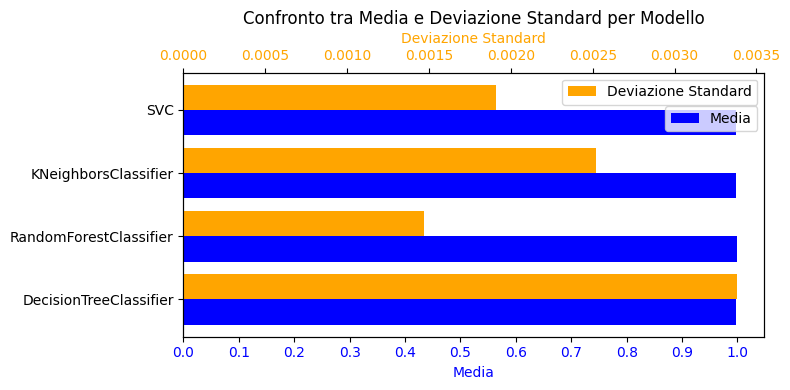

In [73]:
models_names = [f'{clf_dt.__class__.__name__}', f'{clf_rf.__class__.__name__}', f'{clf_knn.__class__.__name__}', f'{clf_svc.__class__.__name__}']
mean_values_undersampler_1m = [mean_accuracy_dt, mean_accuracy_rf, mean_accuracy_knn, mean_accuracy_svc] 
std_values_undersampler_1m = [std_accuracy_dt, std_accuracy_rf, std_accuracy_knn, std_accuracy_svc]

mean_graph_step = 0.1
std_graph_step = 0.0005

yindices = np.arange(len(models_names))

fig, ax1 = plt.subplots(figsize=(8, 4))

bars1 = ax1.barh(yindices - 0.2, mean_values_undersampler_1m, 0.4, label='Media', color='blue')
ax1.set_xlabel('Media', color='blue')
ax1.tick_params(axis='x', labelcolor='blue')

ax2 = ax1.twiny()
bars2 = ax2.barh(yindices + 0.2, std_values_undersampler_1m, 0.4, label='Deviazione Standard', color='orange')
ax2.set_xlabel('Deviazione Standard', color='orange')
ax2.tick_params(axis='x', labelcolor='orange')

ax1.set_title('Confronto tra Media e Deviazione Standard per Modello')
ax1.set_yticks(yindices)
ax1.set_yticklabels(models_names)

ax1.set_xticks(np.arange(0, max(mean_values_undersampler_1m)+mean_graph_step, mean_graph_step))
ax2.set_xticks(np.arange(0, max(std_values_undersampler_1m)+std_graph_step, std_graph_step))

ax1.legend(loc='upper right', bbox_to_anchor=(1, 0.9), fontsize='medium')
ax2.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize='medium')

plt.tight_layout()
plt.show()

##### Without Undersampler - Graph confusion matrix

In [74]:
accuracies_dt = []
accuracies_rf = []
accuracies_knn = []
accuracies_svc = []

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomstate_array[i])
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Decision Tree
    clf_dt = DecisionTreeClassifier(random_state=randomstate_array[i])
    clf_dt.fit(X_train_scaled, y_train)
    y_pred_dt = clf_dt.predict(X_test_scaled)
    accuracy_dt = accuracy_score(y_test, y_pred_dt)
    accuracies_dt.append(accuracy_dt)

    # Random Forest 
    clf_rf = RandomForestClassifier(random_state=randomstate_array[i])
    clf_rf.fit(X_train_scaled, y_train)
    y_pred_rf = clf_rf.predict(X_test_scaled)
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    accuracies_rf.append(accuracy_rf)

    # KNN
    clf_knn = KNeighborsClassifier()
    clf_knn.fit(X_train_scaled, y_train)
    y_pred_knn = clf_knn.predict(X_test_scaled)
    accuracy_knn = accuracy_score(y_test, y_pred_knn)
    accuracies_knn.append(accuracy_knn)

    # SVC
    clf_svc = SVC(random_state=randomstate_array[i])
    clf_svc.fit(X_train_scaled, y_train)
    y_pred_svc = clf_svc.predict(X_test_scaled)
    accuracy_svc = accuracy_score(y_test, y_pred_svc)
    accuracies_svc.append(accuracy_svc)

    if os.path.exists(f"./results/result_notebook_timeaggr_{time_aggregation}s/test_1m_05h"):
        pass
    else:
        os.makedirs(f"./results/result_notebook_timeaggr_{time_aggregation}s/test_1m_05h")

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    for ax, (model_name, cm) in zip(axes.flatten(), iterations_name.items()):
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_title(f'Confusion Matrix: {model_name}')
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')
        plt.tight_layout()
        plt.savefig(f'./results/result_notebook_timeaggr_{time_aggregation}s/test_1m_05h/test_1m_iteration_{i}.png')
    plt.close()



mean_accuracy_dt = np.mean(accuracies_dt)
std_accuracy_dt = np.std(accuracies_dt)

mean_accuracy_rf = np.mean(accuracies_rf)
std_accuracy_rf = np.std(accuracies_rf)

mean_accuracy_knn = np.mean(accuracies_knn)
std_accuracy_knn = np.std(accuracies_knn)

mean_accuracy_svc = np.mean(accuracies_svc)
std_accuracy_svc = np.std(accuracies_svc)

print(f"Media delle accuratezze Decision Tree: {mean_accuracy_dt * 100:.2f}%, Deviazione standard: {std_accuracy_dt * 100:.2f}%")
print(f"Media delle accuratezze Random Forest: {mean_accuracy_rf * 100:.2f}%, Deviazione standard: {std_accuracy_rf * 100:.2f}%")
print(f"Media delle accuratezze KNN: {mean_accuracy_knn * 100:.2f}%, Deviazione standard: {std_accuracy_knn * 100:.2f}%")
print(f"Media delle accuratezze SVC: {mean_accuracy_svc * 100:.2f}%, Deviazione standard: {std_accuracy_svc * 100:.2f}%")

Media delle accuratezze Decision Tree: 99.56%, Deviazione standard: 0.28%
Media delle accuratezze Random Forest: 99.82%, Deviazione standard: 0.17%
Media delle accuratezze KNN: 99.77%, Deviazione standard: 0.25%
Media delle accuratezze SVC: 99.40%, Deviazione standard: 0.68%


###### Graph std-mean of ten accuracies

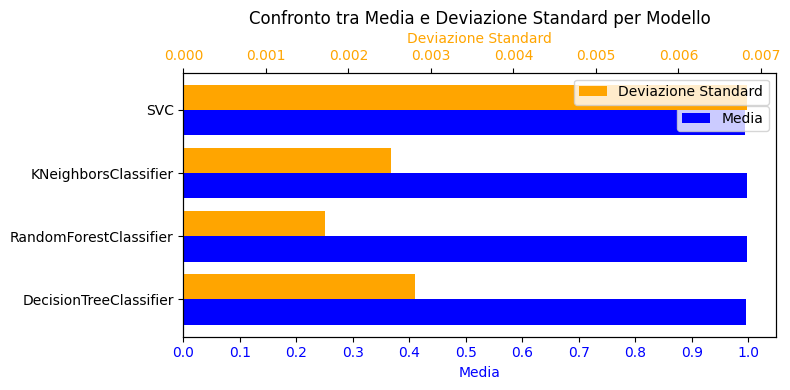

In [76]:
models_names = [f'{clf_dt.__class__.__name__}', f'{clf_rf.__class__.__name__}', f'{clf_knn.__class__.__name__}', f'{clf_svc.__class__.__name__}']
mean_values_1m = [mean_accuracy_dt, mean_accuracy_rf, mean_accuracy_knn, mean_accuracy_svc] 
std_values_1m = [std_accuracy_dt, std_accuracy_rf, std_accuracy_knn, std_accuracy_svc]

mean_graph_step = 0.1
std_graph_step = 0.001

yindices = np.arange(len(models_names))

fig, ax1 = plt.subplots(figsize=(8, 4))

bars1 = ax1.barh(yindices - 0.2, mean_values_1m, 0.4, label='Media', color='blue')
ax1.set_xlabel('Media', color='blue')
ax1.tick_params(axis='x', labelcolor='blue')

ax2 = ax1.twiny()
bars2 = ax2.barh(yindices + 0.2, std_values_1m, 0.4, label='Deviazione Standard', color='orange')
ax2.set_xlabel('Deviazione Standard', color='orange')
ax2.tick_params(axis='x', labelcolor='orange')

ax1.set_title('Confronto tra Media e Deviazione Standard per Modello')
ax1.set_yticks(yindices)
ax1.set_yticklabels(models_names)

ax1.set_xticks(np.arange(0, max(mean_values_1m) + mean_graph_step, mean_graph_step))
ax2.set_xticks(np.arange(0, max(std_values_1m) + std_graph_step, std_graph_step))

ax1.legend(loc='upper right', bbox_to_anchor=(1, 0.9), fontsize='medium')
ax2.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize='medium')

plt.tight_layout()
plt.show()


#### Cumulative graph - With Undersampler

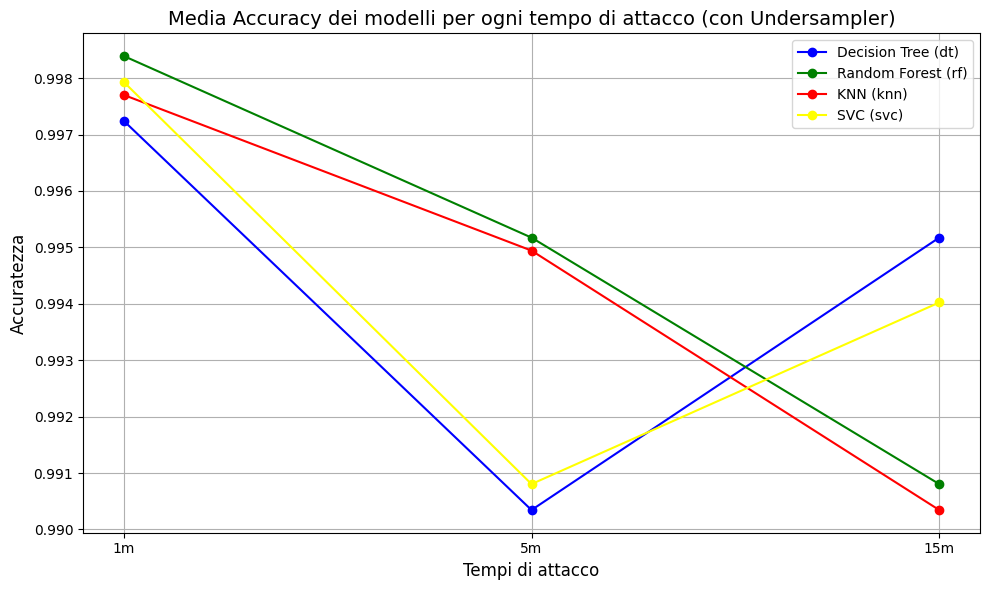

In [ ]:
accuracy_dt = [mean_values_undersampler_1m[0], mean_values_undersampler_5m[0] , mean_values_undersampler_15m[0]]  
accuracy_rf = [mean_values_undersampler_1m[1], mean_values_undersampler_5m[1], mean_values_undersampler_15m[1]] 
accuracy_knn = [mean_values_undersampler_1m[2], mean_values_undersampler_5m[2], mean_values_undersampler_15m[2]]  
accuracy_svc = [mean_values_undersampler_1m[3], mean_values_undersampler_5m[3], mean_values_undersampler_15m[3]]  

tempi_cattura = ['1m', '5m', '15m']

plt.figure(figsize=(10, 6))

plt.plot(tempi_cattura, accuracy_dt, label='Decision Tree (dt)', marker='o', color='blue')
plt.plot(tempi_cattura, accuracy_rf, label='Random Forest (rf)', marker='o', color='green')
plt.plot(tempi_cattura, accuracy_knn, label='KNN (knn)', marker='o', color='red')
plt.plot(tempi_cattura, accuracy_svc, label='SVC (svc)', marker='o', color='yellow')

plt.title('Media Accuracy dei modelli per ogni tempo di attacco (con Undersampler)', fontsize=14)
plt.xlabel('Tempi di attacco', fontsize=12)
plt.ylabel('Accuratezza', fontsize=12)

plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()


#### Cumulative graph - Without Undersampler

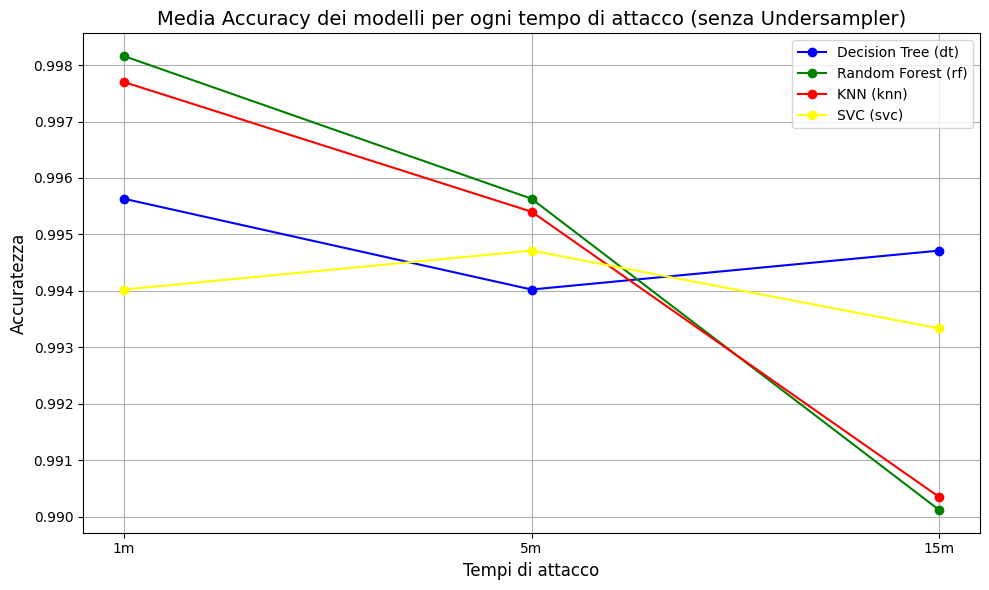

In [78]:
accuracy_dt = [mean_values_1m[0],mean_values_5m[0] , mean_values_15m[0]]  
accuracy_rf = [mean_values_1m[1], mean_values_5m[1], mean_values_15m[1]] 
accuracy_knn = [mean_values_1m[2], mean_values_5m[2], mean_values_15m[2]]  
accuracy_svc = [mean_values_1m[3], mean_values_5m[3], mean_values_15m[3]]  

tempi_cattura = ['1m', '5m', '15m']

plt.figure(figsize=(10, 6))

plt.plot(tempi_cattura, accuracy_dt, label='Decision Tree (dt)', marker='o', color='blue')
plt.plot(tempi_cattura, accuracy_rf, label='Random Forest (rf)', marker='o', color='green')
plt.plot(tempi_cattura, accuracy_knn, label='KNN (knn)', marker='o', color='red')
plt.plot(tempi_cattura, accuracy_svc, label='SVC (svc)', marker='o', color='yellow')

plt.title('Media Accuracy dei modelli per ogni tempo di attacco (senza Undersampler)', fontsize=14)
plt.xlabel('Tempi di attacco', fontsize=12)
plt.ylabel('Accuratezza', fontsize=12)

plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()